# L4 - Xarray

---

10 total points

Due: February 8th, 2026 at 11:59 p.m.

---

Directions:

1. Please rename the file by clicking on "LX-First-Last.ipynb" where X is the lab number, and replace First and Last with your first and last name.
2. Click File -> Save to make sure your most recent edits are saved.
3. In the upper right hand corner of the screen, click on "Share". Click on "Restricted" and change it to "Anyone with the link".
4. Copy the link and submit it on Blackboard. Make sure you follow these steps completely, or I will be unable to grade your work.

---

### Overview

This lab will help you understand xarray and its capabilities. We will walk through some examples of how xarray can help solve Geoscience problems. Periodically, I will 1) ask you to either repeat the demonstrated code in a slightly different way; or 2) ask you to combine two or more techniques to solve a problem.

You can use generative AI to *help* answer these problems. The answer should still be in *your own words*. Think of the generative AI descriptions as those from a book. You still have to cite your source and you cannot plagiarize directly from the source. *For every question that you used generative AI for help*, please reference the generative AI you used and what your prompt or prompts were.

However, it is crucial that you understand the code well enough to effectively use generative AI tools that are likely to be widely available and recommended for use at many organizations. Although they are improving at an incredible rate, they still produce bugs, especially with domain-specific and complex problems. Make sure that you verify the answers before putting them in your own words.

### Download

Make sure that you run the following commands to download the data used for this lab. This dataset includes all [PRISM](https://prism.oregonstate.edu/) precipitation normals for each month.

```%%bash``` uses [Jupyter Magic Commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html) to process bash scripting code. This type of code is commonly used in linux-based systems to do basic file system tasks (renaming and/or moving files, setting up and executing scripts, etc.). In this case, the script loops through a set of numbers 1 - 12 to assist in automating the download and extraction of data used in this notebook.

You only need to run this once per session.

In [1]:
%%bash
set -u
mkdir -p prism_data
base="https://data.prism.oregonstate.edu/normals/us/4km/ppt/monthly"

for m in $(seq -w 1 12); do
  f="prism_ppt_us_25m_2020${m}_avg_30y.zip"
  url="${base}/${f}"

  if [[ ! -s "$f" ]]; then
    echo "[download] $f"
    wget -q -O "$f" "$url"
    rc=$?
    if [[ $rc -ne 0 ]]; then
      echo "[warn] wget failed ($rc) for $url"
      rm -f "$f"
      continue
    fi
  else
    echo "[skip]    $f exists"
  fi

  if ! unzip -tq "$f" >/dev/null 2>&1; then
    echo "[warn]   $f is not a valid zip (maybe HTML/404). Removing."
    rm -f "$f"
    continue
  fi

  echo "[unzip]   $f -> prism_data/"
  unzip -q -n "$f" -d prism_data
  rc=$?
  if [[ $rc -ne 0 ]]; then
    echo "[warn] unzip failed ($rc) for $f"
    continue
  fi
done


[download] prism_ppt_us_25m_202001_avg_30y.zip
[unzip]   prism_ppt_us_25m_202001_avg_30y.zip -> prism_data/
[download] prism_ppt_us_25m_202002_avg_30y.zip
[unzip]   prism_ppt_us_25m_202002_avg_30y.zip -> prism_data/
[download] prism_ppt_us_25m_202003_avg_30y.zip
[unzip]   prism_ppt_us_25m_202003_avg_30y.zip -> prism_data/
[download] prism_ppt_us_25m_202004_avg_30y.zip
[unzip]   prism_ppt_us_25m_202004_avg_30y.zip -> prism_data/
[download] prism_ppt_us_25m_202005_avg_30y.zip
[unzip]   prism_ppt_us_25m_202005_avg_30y.zip -> prism_data/
[download] prism_ppt_us_25m_202006_avg_30y.zip
[unzip]   prism_ppt_us_25m_202006_avg_30y.zip -> prism_data/
[download] prism_ppt_us_25m_202007_avg_30y.zip
[unzip]   prism_ppt_us_25m_202007_avg_30y.zip -> prism_data/
[download] prism_ppt_us_25m_202008_avg_30y.zip
[unzip]   prism_ppt_us_25m_202008_avg_30y.zip -> prism_data/
[download] prism_ppt_us_25m_202009_avg_30y.zip
[unzip]   prism_ppt_us_25m_202009_avg_30y.zip -> prism_data/
[download] prism_ppt_us_25m_

Install the required packages

In [2]:
%%bash
pip install xarray > /dev/null
pip install rioxarray > /dev/null

### Reading and Converting PRISM data

The PRISM data are originally in the [geotiff](https://en.wikipedia.org/wiki/GeoTIFF) raster data format. For this lab, we will use [netCDF]( ) file format. Thus, we will convert the geotiffs to netCDF using the following code that loops through each month of precipitation data, renames some variables, and saves the file in netCDF format. This is not really that relevant to the lab, but I included it for completeness.

In [3]:
import xarray as xr
import rioxarray as rxr
import datetime
import pandas as pd

for month in range(1, 13):

    ds = xr.open_dataset(f"prism_data/prism_ppt_us_25m_2020{month:02d}_avg_30y.tif", engine="rasterio")

    ds = ds.rename({'x': 'lon', 'y': 'lat', 'band_data': 'ppt', 'band': 'time'})

    ds = ds.drop_vars(['spatial_ref'])

    ds = ds.assign_coords(time=[pd.Timestamp(2020, month, 1)])

    gds = rxr.open_rasterio(f"prism_data/prism_ppt_us_25m_2020{month:02d}_avg_30y.tif")

    ds.attrs = gds.attrs

    ds.to_netcdf(f'prism_ppt_us_25m_2020{month:02d}_avg_30y.nc')

    ds.close()

combined = xr.open_mfdataset("*.nc")

combined.to_netcdf("monthly_normals_prism.nc")

combined.close()

### Reading in netCDF files with xarray

This lab will introduce you to how you can read and analyze netCDF files in the Geosciences.

The xarray package greatly simplifies the process of working with n-dimensional data. In other words, you will commonly interact with 3D (or even 4D) data in the Geosciences, and handling that with basic ```numpy``` methods can be tedious.

The most basic use of xarray is reading in a netCDF file. You can do it with the following code. Using the built-in ```display``` method can help you visually examine the data structure.

If you read data in for June, you will see the following:

- ```Dimensions```: Dimensions are similar to indexes in numpy arrays, particularly n-dimensional numpy arrays.

- ```Coordinates```: These define human-readable (usually) labels for dimension indexes. Coordinates include specific times, latitudes, longitudes, etc.

- ```Data variables```: The actual Geoscience data at geographic positions defined by the coordinates. In this case, the dimensions of our Geoscience data are (time, lat, and lon). This is telling us that we could access precipitation data by indexing lat, lon, and/or time.

- ```Attributes```: These are the "metadata" associated with the raw values and coordinates that give us more information about the data. This is a very convenient feature of netCDF data and is usually "packaged" with the data seamlessly.

In [4]:
import xarray as xr

prism = xr.open_dataset("prism_ppt_us_25m_202006_avg_30y.nc")

display(prism)

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 1, lat: 621, lon: 1405)
Coordinates:
  * time     (time) datetime64[ns] 8B 2020-06-01
  * lat      (lat) float64 5kB 49.92 49.88 49.83 49.79 ... 24.17 24.12 24.08
  * lon      (lon) float64 11kB -125.0 -125.0 -124.9 ... -66.58 -66.54 -66.5
Data variables:
    ppt      (time, lat, lon) float64 7MB ...
Attributes: (12/15)
    PRISM_CODE_VERSION:         16.1-20220830-1154
    PRISM_DATASET_CREATE_DATE:  20221129-1501
    PRISM_DATASET_FILENAME:     dem_ppt_us_us_30s_912006.bil
    PRISM_DATASET_REMARKS:      This grid was initially modeled with PRISM at...
    PRISM_DATASET_TYPE:         an91/r2207d, normals/9120.a
    PRISM_DATASET_VERSION:      M4 
    ...                         ...
    STATISTICS_MINIMUM:         0.0
    STATISTICS_NNULL:           390874
    STATISTICS_STDDEV:          46.6015
    _FillValue:                 -9999.0
    scale_factor:               1.0
    add_offset:                 0.0

We can quickly plot these data to see what they look like using the `.plot.imshow()` method. The `squeeze()` method is used to remove the single `time` dimension so you can plot the data on a 2D plot. This is the mean June accumulation of precipitation during the normal period.

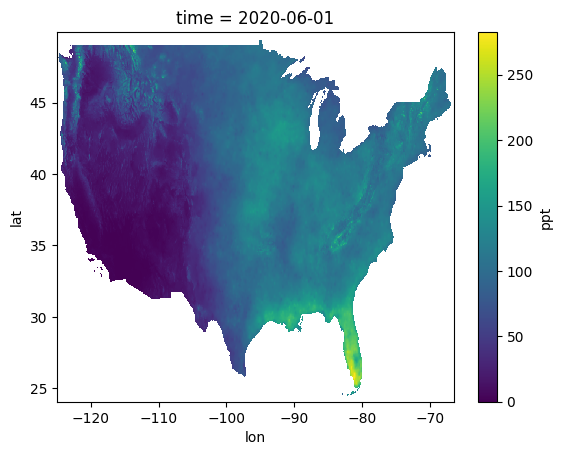

In [5]:
prism['ppt'].squeeze().plot.imshow()

### Problem 1

Run the following code and describe what each value means in your own words. Put your answer in this markdown:



In [6]:
print("prism.dims prints ->", prism.dims)
print("\nprism.sizes prints ->", prism.sizes)
print("\nprism.data_vars prints ->", prism.data_vars)
print("\nprism.coords prints ->", prism.coords)
print("\nprism.attrs prints ->", prism.attrs)

prism.dims prints -> FrozenMappingWarningOnValuesAccess({'time': 1, 'lat': 621, 'lon': 1405})

prism.sizes prints -> Frozen({'time': 1, 'lat': 621, 'lon': 1405})

prism.data_vars prints -> Data variables:
    ppt      (time, lat, lon) float64 7MB ...

prism.coords prints -> Coordinates:
  * time     (time) datetime64[ns] 8B 2020-06-01
  * lat      (lat) float64 5kB 49.92 49.88 49.83 49.79 ... 24.17 24.12 24.08
  * lon      (lon) float64 11kB -125.0 -125.0 -124.9 ... -66.58 -66.54 -66.5

prism.attrs prints -> {'PRISM_CODE_VERSION': '16.1-20220830-1154', 'PRISM_DATASET_CREATE_DATE': '20221129-1501', 'PRISM_DATASET_FILENAME': 'dem_ppt_us_us_30s_912006.bil', 'PRISM_DATASET_REMARKS': 'This grid was initially modeled with PRISM at 30-arc-second (~800-m) resolution to produce the source grid listed under PRISM_FILENAME, on the date(s) listed under PRISM_CREATE_DATE. This source grid was then upscaled to 2.5-arc-minute (~4-km) resolution with a Gaussian filter.', 'PRISM_DATASET_TYPE': 'an91/r2

### Problem 2

There are two different ways to index data in the `xarray` `dataset`.

1. `.sel(...)`: This requires selecting by the coordinate label. More similar to how data are accessed in `pandas`. If using `float` data, you need to include the argument `method='nearest'` because of [floating point rounding and precision issues](https://en.wikipedia.org/wiki/Floating-point_arithmetic#Representable_numbers,_conversion_and_rounding).
2. `.isel(...)`: This requires selecting by the `integer` index. More similar to how data are accessed in `numpy`.

Interpret the output below in your own words. Specifically, explain (in this markdown) how two different indexing approaches got the same result?





In [7]:
result_isel = prism.isel(lat=300, lon=1000, time=0)
result_sel = prism.sel(lat=37.42, lon=-83.33, time='2020-06-01', method='nearest')

print("output from prism.isel")
display(result_isel)
print("output from prism.sel")
display(result_sel)

print("value at isel index: ", float(result_isel['ppt']))
print("value at sel index: ", float(result_sel['ppt']))

output from prism.isel


<xarray.Dataset> Size: 32B
Dimensions:  ()
Coordinates:
    lon      float64 8B -83.33
    lat      float64 8B 37.42
    time     datetime64[ns] 8B 2020-06-01
Data variables:
    ppt      float64 8B ...
Attributes: (12/15)
    PRISM_CODE_VERSION:         16.1-20220830-1154
    PRISM_DATASET_CREATE_DATE:  20221129-1501
    PRISM_DATASET_FILENAME:     dem_ppt_us_us_30s_912006.bil
    PRISM_DATASET_REMARKS:      This grid was initially modeled with PRISM at...
    PRISM_DATASET_TYPE:         an91/r2207d, normals/9120.a
    PRISM_DATASET_VERSION:      M4 
    ...                         ...
    STATISTICS_MINIMUM:         0.0
    STATISTICS_NNULL:           390874
    STATISTICS_STDDEV:          46.6015
    _FillValue:                 -9999.0
    scale_factor:               1.0
    add_offset:                 0.0

output from prism.sel


<xarray.Dataset> Size: 32B
Dimensions:  ()
Coordinates:
    lon      float64 8B -83.33
    lat      float64 8B 37.42
    time     datetime64[ns] 8B 2020-06-01
Data variables:
    ppt      float64 8B ...
Attributes: (12/15)
    PRISM_CODE_VERSION:         16.1-20220830-1154
    PRISM_DATASET_CREATE_DATE:  20221129-1501
    PRISM_DATASET_FILENAME:     dem_ppt_us_us_30s_912006.bil
    PRISM_DATASET_REMARKS:      This grid was initially modeled with PRISM at...
    PRISM_DATASET_TYPE:         an91/r2207d, normals/9120.a
    PRISM_DATASET_VERSION:      M4 
    ...                         ...
    STATISTICS_MINIMUM:         0.0
    STATISTICS_NNULL:           390874
    STATISTICS_STDDEV:          46.6015
    _FillValue:                 -9999.0
    scale_factor:               1.0
    add_offset:                 0.0

value at isel index:  122.45050048828125
value at sel index:  122.45050048828125


### Problem 3

All in the following code cell, open the netCDF file that represents January normals and set it equal to a variable named `jan`. Then, do the same for May (`may`). Find DeKalb's lat/lon coordinates and use them with `sel` on both `may` and `jan` and print the value at that point. Convert it to inches. Does this make sense to you? What month has a higher normal precipitation amount for DeKalb? Answer in this markdown.

### Problem 4

We will now explore the ability of xarray to work with 3-dimensional data. There is a file named `monthly_normals_prism.nc` that contains the combined values for each month in one file.

Notice when displaying the `xarray` `dataset`, the `time` dimension is now equal to `12`. We can examine the coordinate values by printing out ```prism_all.time```.

In your own words, explain "where" DeKalb's normals for June exist in the 3D data structure from the perspective of:

1. `prism_all.sel(..)`

2. `prism_all.isel(..)`

In [8]:
prism_all = xr.open_dataset("monthly_normals_prism.nc")

display(prism_all)

print("These are the `time` coordinates ->", prism_all.time)

<xarray.Dataset> Size: 84MB
Dimensions:  (time: 12, lat: 621, lon: 1405)
Coordinates:
  * time     (time) datetime64[ns] 96B 2020-01-01 2020-02-01 ... 2020-12-01
  * lat      (lat) float64 5kB 49.92 49.88 49.83 49.79 ... 24.17 24.12 24.08
  * lon      (lon) float64 11kB -125.0 -125.0 -124.9 ... -66.58 -66.54 -66.5
Data variables:
    ppt      (time, lat, lon) float64 84MB ...
Attributes: (12/15)
    PRISM_CODE_VERSION:         16.1-20220830-1154
    PRISM_DATASET_CREATE_DATE:  20221129-1501
    PRISM_DATASET_FILENAME:     dem_ppt_us_us_30s_912001.bil
    PRISM_DATASET_REMARKS:      This grid was initially modeled with PRISM at...
    PRISM_DATASET_TYPE:         an91/r2207d, normals/9120.a
    PRISM_DATASET_VERSION:      M4 
    ...                         ...
    STATISTICS_MINIMUM:         4.1087
    STATISTICS_NNULL:           390874
    STATISTICS_STDDEV:          60.994
    _FillValue:                 -9999.0
    scale_factor:               1.0
    add_offset:                 0.0

These are the `time` coordinates -> <xarray.DataArray 'time' (time: 12)> Size: 96B
array(['2020-01-01T00:00:00.000000000', '2020-02-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-04-01T00:00:00.000000000',
       '2020-05-01T00:00:00.000000000', '2020-06-01T00:00:00.000000000',
       '2020-07-01T00:00:00.000000000', '2020-08-01T00:00:00.000000000',
       '2020-09-01T00:00:00.000000000', '2020-10-01T00:00:00.000000000',
       '2020-11-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 96B 2020-01-01 2020-02-01 ... 2020-12-01


### Problem 5

`xarray`'s most useful methods include simple mathematical operations that we have used before with numpy: mean, sum, max, min, std, percentile/quantile. We can take advantage of the coordinates to transform our Geoscience expectations and best practices into simple method calls.

In your own words, explain the different results you see in the following code examples, including the size/shape of the resulting dimensions. How are they different from the original shape of (time: 12 lat: 621 lon: 1405). What would you call these results in more basic terms in your Geoscience area?

1. `prism_all.mean()`
2. `prism_all.mean('time')`
3. `prism_all.mean(('lat', 'lon'))`

In [9]:
mean1 = prism_all.mean()
mean2 = prism_all.mean('time')
mean3 = prism_all.mean(('lat', 'lon'))

print("the result of prism_all.mean() ->")
display(mean1)

print("the result of prism_all.mean('time') ->")
display(mean2)

print("the result of prism_all.mean(('lat', 'lon')) ->")
display(mean3)

the result of prism_all.mean() ->


<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    ppt      float64 8B 67.39
Attributes: (12/15)
    PRISM_CODE_VERSION:         16.1-20220830-1154
    PRISM_DATASET_CREATE_DATE:  20221129-1501
    PRISM_DATASET_FILENAME:     dem_ppt_us_us_30s_912001.bil
    PRISM_DATASET_REMARKS:      This grid was initially modeled with PRISM at...
    PRISM_DATASET_TYPE:         an91/r2207d, normals/9120.a
    PRISM_DATASET_VERSION:      M4 
    ...                         ...
    STATISTICS_MINIMUM:         4.1087
    STATISTICS_NNULL:           390874
    STATISTICS_STDDEV:          60.994
    _FillValue:                 -9999.0
    scale_factor:               1.0
    add_offset:                 0.0

the result of prism_all.mean('time') ->


<xarray.Dataset> Size: 7MB
Dimensions:  (lat: 621, lon: 1405)
Coordinates:
  * lat      (lat) float64 5kB 49.92 49.88 49.83 49.79 ... 24.17 24.12 24.08
  * lon      (lon) float64 11kB -125.0 -125.0 -124.9 ... -66.58 -66.54 -66.5
Data variables:
    ppt      (lat, lon) float64 7MB nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/15)
    PRISM_CODE_VERSION:         16.1-20220830-1154
    PRISM_DATASET_CREATE_DATE:  20221129-1501
    PRISM_DATASET_FILENAME:     dem_ppt_us_us_30s_912001.bil
    PRISM_DATASET_REMARKS:      This grid was initially modeled with PRISM at...
    PRISM_DATASET_TYPE:         an91/r2207d, normals/9120.a
    PRISM_DATASET_VERSION:      M4 
    ...                         ...
    STATISTICS_MINIMUM:         4.1087
    STATISTICS_NNULL:           390874
    STATISTICS_STDDEV:          60.994
    _FillValue:                 -9999.0
    scale_factor:               1.0
    add_offset:                 0.0

the result of prism_all.mean(('lat', 'lon')) ->


<xarray.Dataset> Size: 192B
Dimensions:  (time: 12)
Coordinates:
  * time     (time) datetime64[ns] 96B 2020-01-01 2020-02-01 ... 2020-12-01
Data variables:
    ppt      (time) float64 96B 61.12 55.05 65.33 69.84 ... 65.01 59.62 65.76
Attributes: (12/15)
    PRISM_CODE_VERSION:         16.1-20220830-1154
    PRISM_DATASET_CREATE_DATE:  20221129-1501
    PRISM_DATASET_FILENAME:     dem_ppt_us_us_30s_912001.bil
    PRISM_DATASET_REMARKS:      This grid was initially modeled with PRISM at...
    PRISM_DATASET_TYPE:         an91/r2207d, normals/9120.a
    PRISM_DATASET_VERSION:      M4 
    ...                         ...
    STATISTICS_MINIMUM:         4.1087
    STATISTICS_NNULL:           390874
    STATISTICS_STDDEV:          60.994
    _FillValue:                 -9999.0
    scale_factor:               1.0
    add_offset:                 0.0

### Problem 6

Create a time series for DeKalb.

In `xarray` terms, a time series contains data from a coordinate that does not vary in space (a fixed location), but does vary in time.

Use it to complete the following line graph plot:

Text(0, 0.5, 'Precipitation Accumulation (inches)')

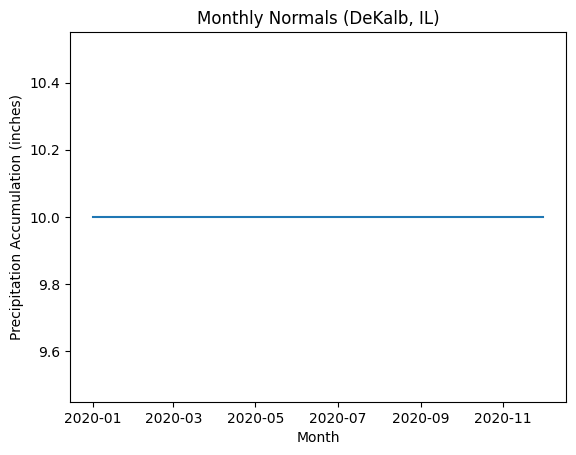

In [10]:
import matplotlib.pyplot as plt

plt.title("Monthly Normals (DeKalb, IL)")

# dummy data, replace with your data
plt.plot(prism_all.time, [10]*12)

plt.xlabel("Month")
plt.ylabel("Precipitation Accumulation (inches)")


### Problem 7

Create a [Hovmoller diagram](https://en.wikipedia.org/wiki/Hovm%C3%B6ller_diagram) from `prism_all` to show how the precipitation totals along a line of longitude shift west and east from month to month.

In `xarray` terms, a Hovmoller replaces the `lat` (y) dimension with the `time` dimension, but keeps the `lon` (x) dimension. This is then plotted as a 2D image to examine how meteorological phenomena generally move over the course of a day or year in an east-west perspective.

Set the result to a variable named `hov`, use `display` to show its data structure, and use `hov['ppt'].plot.imshow()` to visually plot the result.

HINT: the final shape should be (time: 12 lon: 1405)

## Problem 8

`xarray` can also [group](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html) and [resample](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.resample.html) like `pandas`.

We can use a combination of `resample` and mathematical methods to create meaningful Geoscience results.

In the case of `prism_all`, where there are 12 months of climate normal data, we might want to group months together into seasons.

We can use a special property of the `time` dimension when grouped in xarray: `time.season`. This converts all of the `time` data (in this case, the date of the start of each month) to group months together into:

1. DJF - Dec, Jan, Feb
2. MAM - Mar, Apr, May
3. JJA - Jun, Jul, Aug
4. SON - Sep, Oct, Nov

We can loop through the result to visualize the data structure of each group. In your own words, describe the shape of each seasonal result and your interpretation of each dimension. Place your answer in this markdown.

In [11]:
for season_name, season_data in prism_all.groupby('time.season'):

    print("Seasonal data for season_name =", season_name, "->\n")

    display(season_data)

Seasonal data for season_name = DJF ->



<xarray.Dataset> Size: 21MB
Dimensions:  (time: 3, lat: 621, lon: 1405)
Coordinates:
  * time     (time) datetime64[ns] 24B 2020-01-01 2020-02-01 2020-12-01
  * lat      (lat) float64 5kB 49.92 49.88 49.83 49.79 ... 24.17 24.12 24.08
  * lon      (lon) float64 11kB -125.0 -125.0 -124.9 ... -66.58 -66.54 -66.5
Data variables:
    ppt      (time, lat, lon) float64 21MB nan nan nan nan ... nan nan nan nan
Attributes: (12/15)
    PRISM_CODE_VERSION:         16.1-20220830-1154
    PRISM_DATASET_CREATE_DATE:  20221129-1501
    PRISM_DATASET_FILENAME:     dem_ppt_us_us_30s_912001.bil
    PRISM_DATASET_REMARKS:      This grid was initially modeled with PRISM at...
    PRISM_DATASET_TYPE:         an91/r2207d, normals/9120.a
    PRISM_DATASET_VERSION:      M4 
    ...                         ...
    STATISTICS_MINIMUM:         4.1087
    STATISTICS_NNULL:           390874
    STATISTICS_STDDEV:          60.994
    _FillValue:                 -9999.0
    scale_factor:               1.0
    add_offset:                 0.0

Seasonal data for season_name = JJA ->



<xarray.Dataset> Size: 21MB
Dimensions:  (time: 3, lat: 621, lon: 1405)
Coordinates:
  * time     (time) datetime64[ns] 24B 2020-06-01 2020-07-01 2020-08-01
  * lat      (lat) float64 5kB 49.92 49.88 49.83 49.79 ... 24.17 24.12 24.08
  * lon      (lon) float64 11kB -125.0 -125.0 -124.9 ... -66.58 -66.54 -66.5
Data variables:
    ppt      (time, lat, lon) float64 21MB nan nan nan nan ... nan nan nan nan
Attributes: (12/15)
    PRISM_CODE_VERSION:         16.1-20220830-1154
    PRISM_DATASET_CREATE_DATE:  20221129-1501
    PRISM_DATASET_FILENAME:     dem_ppt_us_us_30s_912001.bil
    PRISM_DATASET_REMARKS:      This grid was initially modeled with PRISM at...
    PRISM_DATASET_TYPE:         an91/r2207d, normals/9120.a
    PRISM_DATASET_VERSION:      M4 
    ...                         ...
    STATISTICS_MINIMUM:         4.1087
    STATISTICS_NNULL:           390874
    STATISTICS_STDDEV:          60.994
    _FillValue:                 -9999.0
    scale_factor:               1.0
    add_offset:                 0.0

Seasonal data for season_name = MAM ->



<xarray.Dataset> Size: 21MB
Dimensions:  (time: 3, lat: 621, lon: 1405)
Coordinates:
  * time     (time) datetime64[ns] 24B 2020-03-01 2020-04-01 2020-05-01
  * lat      (lat) float64 5kB 49.92 49.88 49.83 49.79 ... 24.17 24.12 24.08
  * lon      (lon) float64 11kB -125.0 -125.0 -124.9 ... -66.58 -66.54 -66.5
Data variables:
    ppt      (time, lat, lon) float64 21MB nan nan nan nan ... nan nan nan nan
Attributes: (12/15)
    PRISM_CODE_VERSION:         16.1-20220830-1154
    PRISM_DATASET_CREATE_DATE:  20221129-1501
    PRISM_DATASET_FILENAME:     dem_ppt_us_us_30s_912001.bil
    PRISM_DATASET_REMARKS:      This grid was initially modeled with PRISM at...
    PRISM_DATASET_TYPE:         an91/r2207d, normals/9120.a
    PRISM_DATASET_VERSION:      M4 
    ...                         ...
    STATISTICS_MINIMUM:         4.1087
    STATISTICS_NNULL:           390874
    STATISTICS_STDDEV:          60.994
    _FillValue:                 -9999.0
    scale_factor:               1.0
    add_offset:                 0.0

Seasonal data for season_name = SON ->



<xarray.Dataset> Size: 21MB
Dimensions:  (time: 3, lat: 621, lon: 1405)
Coordinates:
  * time     (time) datetime64[ns] 24B 2020-09-01 2020-10-01 2020-11-01
  * lat      (lat) float64 5kB 49.92 49.88 49.83 49.79 ... 24.17 24.12 24.08
  * lon      (lon) float64 11kB -125.0 -125.0 -124.9 ... -66.58 -66.54 -66.5
Data variables:
    ppt      (time, lat, lon) float64 21MB nan nan nan nan ... nan nan nan nan
Attributes: (12/15)
    PRISM_CODE_VERSION:         16.1-20220830-1154
    PRISM_DATASET_CREATE_DATE:  20221129-1501
    PRISM_DATASET_FILENAME:     dem_ppt_us_us_30s_912001.bil
    PRISM_DATASET_REMARKS:      This grid was initially modeled with PRISM at...
    PRISM_DATASET_TYPE:         an91/r2207d, normals/9120.a
    PRISM_DATASET_VERSION:      M4 
    ...                         ...
    STATISTICS_MINIMUM:         4.1087
    STATISTICS_NNULL:           390874
    STATISTICS_STDDEV:          60.994
    _FillValue:                 -9999.0
    scale_factor:               1.0
    add_offset:                 0.0

### Problem 9

Explain the differences between the examples below in "general terms".

1. `prism_all.groupby('time.season').sum()`
2. `prism_all.groupby('time.season').mean()`
3. `prism_all.groupby('time.season').max()`

In other words, what is this showing and what is the significance of these results in your Geoscience domain? What do you notice about the resulting dimensions and coordinates? How do the dimensions help you understand the result? Place your answer in this markdown.

In [12]:
seas_sum = prism_all.groupby('time.season').sum()
seas_mean = prism_all.groupby('time.season').mean()
seas_max = prism_all.groupby('time.season').max()

print("result of season sum ->\n")
display(seas_sum)

print("result of season mean ->\n")
display(seas_mean)

print("result of season max ->\n")
display(seas_max)

result of season sum ->



<xarray.Dataset> Size: 28MB
Dimensions:  (season: 4, lat: 621, lon: 1405)
Coordinates:
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
  * lat      (lat) float64 5kB 49.92 49.88 49.83 49.79 ... 24.17 24.12 24.08
  * lon      (lon) float64 11kB -125.0 -125.0 -124.9 ... -66.58 -66.54 -66.5
Data variables:
    ppt      (season, lat, lon) float64 28MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/15)
    PRISM_CODE_VERSION:         16.1-20220830-1154
    PRISM_DATASET_CREATE_DATE:  20221129-1501
    PRISM_DATASET_FILENAME:     dem_ppt_us_us_30s_912001.bil
    PRISM_DATASET_REMARKS:      This grid was initially modeled with PRISM at...
    PRISM_DATASET_TYPE:         an91/r2207d, normals/9120.a
    PRISM_DATASET_VERSION:      M4 
    ...                         ...
    STATISTICS_MINIMUM:         4.1087
    STATISTICS_NNULL:           390874
    STATISTICS_STDDEV:          60.994
    _FillValue:                 -9999.0
    scale_factor:               1.0
    add_offset:                 0.0

result of season mean ->



<xarray.Dataset> Size: 28MB
Dimensions:  (season: 4, lat: 621, lon: 1405)
Coordinates:
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
  * lat      (lat) float64 5kB 49.92 49.88 49.83 49.79 ... 24.17 24.12 24.08
  * lon      (lon) float64 11kB -125.0 -125.0 -124.9 ... -66.58 -66.54 -66.5
Data variables:
    ppt      (season, lat, lon) float64 28MB nan nan nan nan ... nan nan nan nan
Attributes: (12/15)
    PRISM_CODE_VERSION:         16.1-20220830-1154
    PRISM_DATASET_CREATE_DATE:  20221129-1501
    PRISM_DATASET_FILENAME:     dem_ppt_us_us_30s_912001.bil
    PRISM_DATASET_REMARKS:      This grid was initially modeled with PRISM at...
    PRISM_DATASET_TYPE:         an91/r2207d, normals/9120.a
    PRISM_DATASET_VERSION:      M4 
    ...                         ...
    STATISTICS_MINIMUM:         4.1087
    STATISTICS_NNULL:           390874
    STATISTICS_STDDEV:          60.994
    _FillValue:                 -9999.0
    scale_factor:               1.0
    add_offset:                 0.0

result of season max ->



<xarray.Dataset> Size: 28MB
Dimensions:  (season: 4, lat: 621, lon: 1405)
Coordinates:
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
  * lat      (lat) float64 5kB 49.92 49.88 49.83 49.79 ... 24.17 24.12 24.08
  * lon      (lon) float64 11kB -125.0 -125.0 -124.9 ... -66.58 -66.54 -66.5
Data variables:
    ppt      (season, lat, lon) float64 28MB nan nan nan nan ... nan nan nan nan
Attributes: (12/15)
    PRISM_CODE_VERSION:         16.1-20220830-1154
    PRISM_DATASET_CREATE_DATE:  20221129-1501
    PRISM_DATASET_FILENAME:     dem_ppt_us_us_30s_912001.bil
    PRISM_DATASET_REMARKS:      This grid was initially modeled with PRISM at...
    PRISM_DATASET_TYPE:         an91/r2207d, normals/9120.a
    PRISM_DATASET_VERSION:      M4 
    ...                         ...
    STATISTICS_MINIMUM:         4.1087
    STATISTICS_NNULL:           390874
    STATISTICS_STDDEV:          60.994
    _FillValue:                 -9999.0
    scale_factor:               1.0
    add_offset:                 0.0

### Problem 10

Calculate the month with the highest precipitation total using `prism_all` and save the result in a variable named `max_month`. This should have the dimensions (lat: 621 lon: 1405) and should be plotted using `max_month.plot.imshow`